In [5]:
# %load_ext cudf.pandas
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# TODO: delete this
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df = train_df.copy()


In [10]:
train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


# Exploratory Data Analysis

### Severity Impairment Index
First, we'll look at the distribution of `sii` data

In [11]:
sii_data = train_df['sii'].value_counts().reset_index()
sii_data.columns = ['sii_label', 'count']
sii_data['percent_of_total'] = round((sii_data['count'] / len(train_df)) * 100,1)
sii_data
print(f"{sii_data}\n")
print(f"{100.0*train_df['sii'].isnull().sum()/len(train_df):.2f}% of the sii data is null")

   sii_label  count  percent_of_total
0        0.0   1594              40.3
1        1.0    730              18.4
2        2.0    378               9.5
3        3.0     34               0.9

30.91% of the sii data is null


### Demographics
Let's look through the data related to demographics

In [12]:
df['Basic_Demos-Sex'].value_counts()

Basic_Demos-Sex
0    2484
1    1476
Name: count, dtype: int64

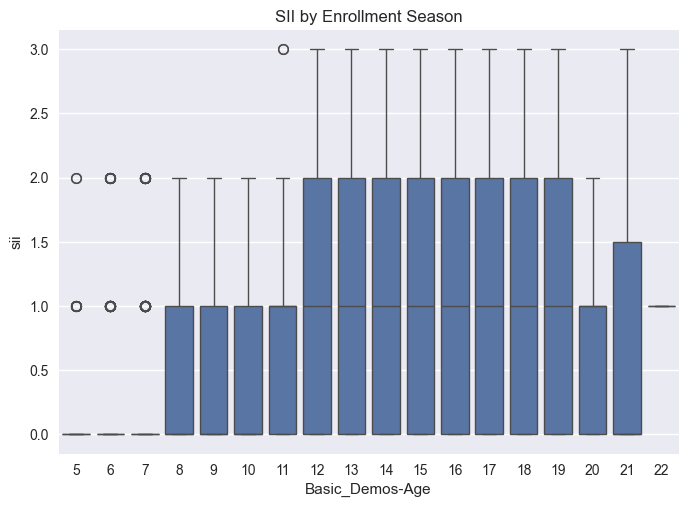

In [14]:
plt.style.use('seaborn-v0_8')
sns.boxplot(x='Basic_Demos-Age', y='sii', data=train_df)
plt.title('SII by Enrollment Season')

plt.show()

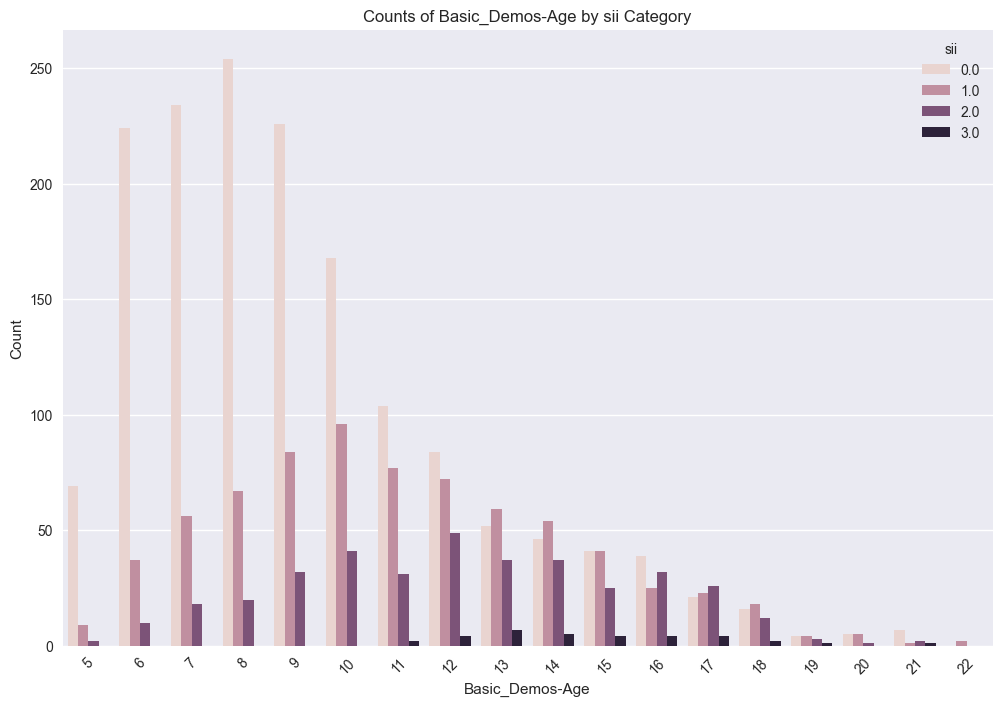

In [15]:
age_sii_counts = train_df.groupby(['Basic_Demos-Age', 'sii']).size().reset_index(name='count')
plt.figure(figsize=(12, 8))
sns.barplot(data=age_sii_counts, x='Basic_Demos-Age', y='count', hue='sii')
plt.title('Counts of Basic_Demos-Age by sii Category')
plt.xlabel('Basic_Demos-Age')
plt.ylabel('Count')
plt.legend(title='sii')
plt.xticks(rotation=45)
plt.show()

Here's what we learned:
* We learned that our dataset is mostly males, about 63% male to 37% female
* Also, the interquartile range of `sii` increases with older ages. 
* Younger ages are prone to less severe impairment
* The magnitude of the severity changes based on the age in consideration. E.g.
    * 0 risk - 8 yrs old
    * 1 risk - 10 yrs old
    * 2 risk - 12 yrs old
    * 3 risk - 13 yrs old

Not shown:
* No trend between `Basic_Demos-Enroll_Season` and `sii`

### Children's Global Assessment Scale

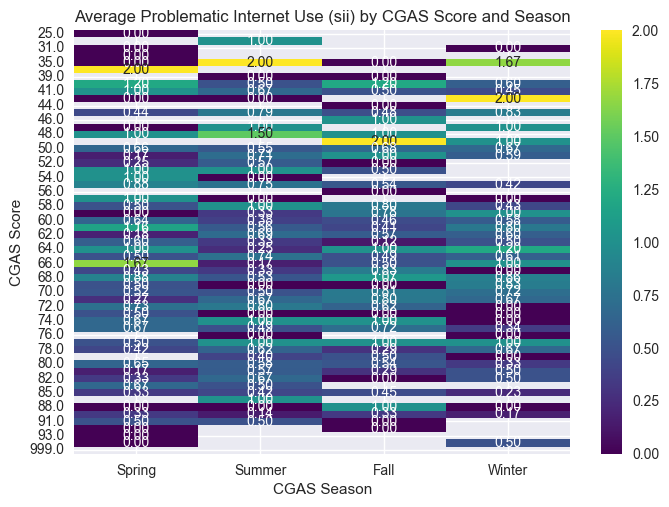

In [16]:
heatmap_data = train_df.groupby(['CGAS-CGAS_Score', 'CGAS-Season'])['sii'].mean().reset_index()
heatmap_data = heatmap_data.pivot(index='CGAS-CGAS_Score', columns='CGAS-Season', values='sii')
column_order = ["Spring", "Summer", "Fall", "Winter"]
heatmap_data = heatmap_data.reindex(columns=column_order) # want the seasons to be in chronological
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f") 
plt.title('Average Problematic Internet Use (sii) by CGAS Score and Season')
plt.xlabel('CGAS Season')
plt.ylabel('CGAS Score')
plt.show()

No notable trends seen in the Children's Global Assessment Scale. Let's move on to the next instrument

### Physical Measures

In [17]:
train_df[['Physical-Season', 'Physical-BMI','Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference','Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']].describe()

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
count,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000
mean,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074
std,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225
min,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000
25%,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000
50%,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000
75%,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000
max,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000


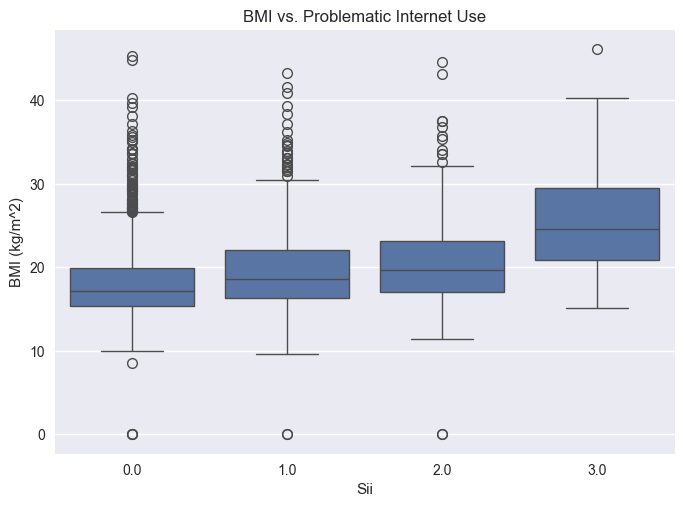

In [18]:
sns.boxplot(x='sii', y='Physical-BMI', data=train_df)
plt.title('BMI vs. Problematic Internet Use')
plt.xlabel('Sii')
plt.ylabel('BMI (kg/m^2)')
plt.show()


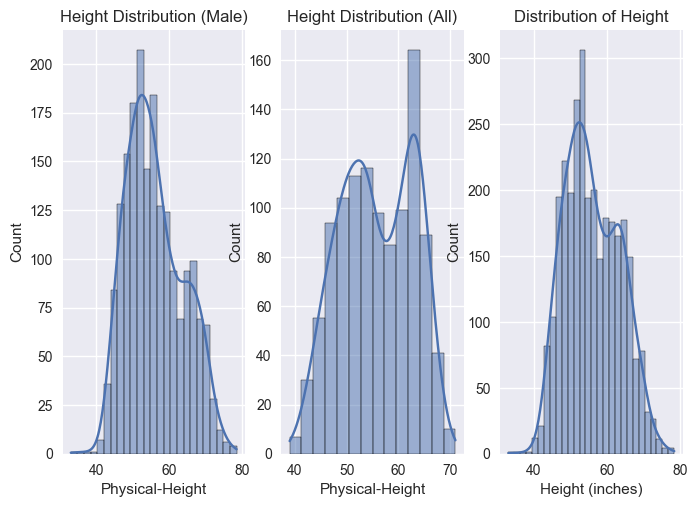

In [ ]:
fig, axes = plt.subplots(1, 3)
sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 0]['Physical-Height'], kde=True, ax=axes[0])
axes[0].set_title('Height Distribution (Male)')

sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 1]['Physical-Height'], kde=True, ax=axes[1])
axes[1].set_title('Height Distribution (Female)')

sns.histplot(train_df['Physical-Height'], kde=True, ax=axes[2])
axes[1].set_title('Height Distribution (All)')

plt.title('Distribution of Height')
plt.xlabel('Height (inches)')
plt.show()

Here's what we learned: 
- Higher BMI corresponds to higher `sii`. The 50 percentile of BMI for "Severe" sii is higher than the 75 percentile for "Moderate" sii
- There was minimal variance in the season w.r.t. the `sii`
- The distribution of heights seemed to take on the form of a bimodal distribution instead of a typical normal distribution. This is likely because males and females are different heights, so the resulting histogram has 2 peaks. The males are the shorter peak because they are typically shorter in the age range collected in this dataset.

### FitnessGram Vitals and Treadmill

In [43]:
list(train_df.filter(like='Fitness_Endurance').columns)

['Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec']

In [46]:
train_df[['Fitness_Endurance-Max_Stage','Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec','sii']].corr()

,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,sii
Fitness_Endurance-Max_Stage,1.000000,0.873138,-0.138393,-0.070589
Fitness_Endurance-Time_Mins,0.873138,1.000000,-0.201425,-0.060628
Fitness_Endurance-Time_Sec,-0.138393,-0.201425,1.000000,0.008701
sii,-0.070589,-0.060628,0.008701,1.000000


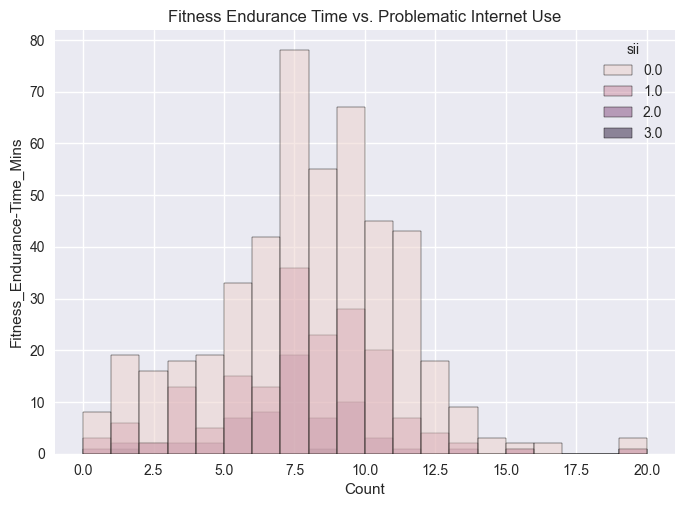

In [36]:
sns.histplot(train_df, x='Fitness_Endurance-Time_Mins',bins=20, hue='sii')
plt.title('Fitness Endurance Time vs. Problematic Internet Use')
plt.xlabel('Count')
plt.ylabel('Fitness_Endurance-Time_Mins')
plt.show()


Here's what we learned:
- `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec` should be combined into 1 column. This will be done later
- There wasnt a strong correlation with any of these columns and `sii`

### FitnessGram Child

In [61]:
fgc_cols = list(train_df.filter(like='FGC').columns) + ['sii']
train_df[fgc_cols].describe()


,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,sii
count,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,2736.000000
mean,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,0.580409
std,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,0.771122
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,15.100000,1.000000,16.200000,2.000000,0.000000,0.000000,7.000000,0.000000,7.000000,0.000000,7.000000,1.000000,0.000000
50%,9.000000,0.000000,20.050000,2.000000,21.200000,2.000000,3.000000,0.000000,9.000000,1.000000,9.000000,1.000000,10.000000,1.000000,0.000000
75%,15.750000,1.000000,26.600000,2.000000,28.175000,2.000000,9.000000,1.000000,11.000000,1.000000,11.000000,1.000000,12.000000,1.000000,1.000000
max,115.000000,1.000000,124.000000,3.000000,123.800000,3.000000,51.000000,1.000000,21.700000,1.000000,21.000000,1.000000,22.000000,1.000000,3.000000


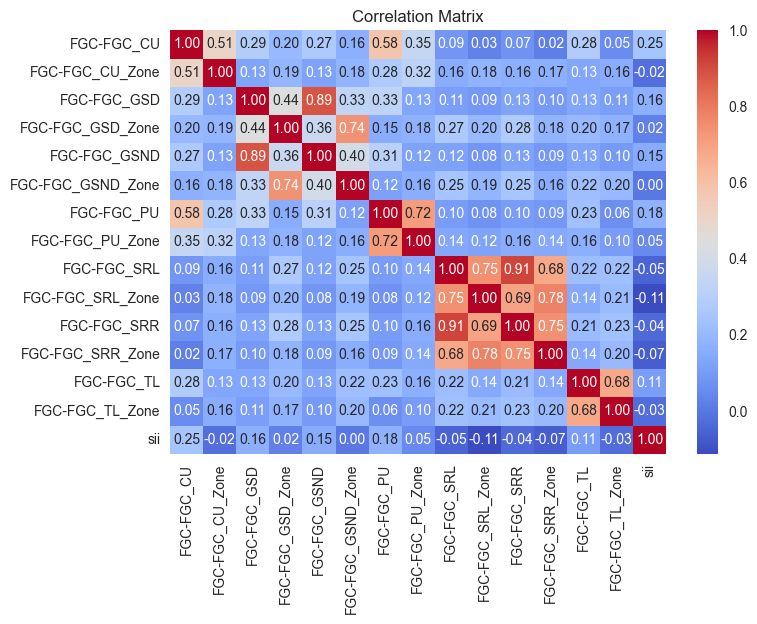

In [69]:
corr_matrix = train_df[fgc_cols].drop(columns=['FGC-Season']).corr()
sorted_cols = corr_matrix.columns.sort_values()
sorted_corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]

sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Here's what we learned:
- Interestingly, there isn't as high of a correlation between the raw values and the categorized "zones". 
    - The highest observed correlation between a category and its zone was only 0.75 for `FGC_FGC_SRR` and `FGC_FGC_SRL`. (These two measurements are just the left and right legs of the Sit & Reach.)
- 


In [ ]:
train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0


The test set does not have any of the PCIAT data, and we're missing about 30% of the `sii` label in the training data. 

In [7]:
pciat_aggs = train_df.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max', 'mean'])
pciat_aggs = pciat_aggs.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score', 'mean': 'Average total PCIAT Score'}
)
pciat_aggs

,Minimum PCIAT total Score,Maximum total PCIAT Score,Average total PCIAT Score
sii,,,
0.0,0.0,30.0,13.929737
1.0,31.0,49.0,38.726027
2.0,50.0,79.0,60.658730
3.0,80.0,93.0,85.911765


The sum of the PCIAT scores all align with the classification set by the Severity Impairment Index (sii)

In [9]:
# List all columns that are of the form PCIAT-PCIAT_XX
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]

# Check if the sum of all PCIAT columns is equal to the PCIAT-PCIAT_Total column. Handle nulls with fillna(0)
train_df['PCIAT_summed_total'] = train_df[pciat_columns].fillna(0).sum(axis=1)
is_calculated_sum_equal_to_total_column = train_df['PCIAT_summed_total'] == train_df['PCIAT-PCIAT_Total'].fillna(0)
is_calculated_sum_equal_to_total_column.sum() == len(train_df)

np.True_

The number of instances where PCIAT-PCIAT_1 -> PCIAT-PCIAT_20 is equal to PCIAT-PCIAT_Total is equal to the number of records in the dataset. This shows that PCIAT-PCIAT_Total is 100% is a linear transformation of other features in this dataset, so we can drop it from the dataset

In [10]:
train_df.drop(columns=['PCIAT_summed_total'], inplace=True)